<a href="https://colab.research.google.com/github/atick-faisal/GRF-Synthesis-from-Motion-Trajectories/blob/main/src/training/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG Motion Artifact Removal using Deep Learning - Complete Pipeline

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: Tesla K80
GPU Capability: (3, 7)
Is GPU Initialized yet? True


# Connect to Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/GDrive')

Move to the Target Directory

In [3]:
# %cd /content/GDrive/MyDrive/Colab_Notebooks/Research/EEG_IMU 

List the Files and Folders Located in the Current Directory

In [4]:
# !ls

## Evaluation of Predicting ABP Waveforms

Here, we present an interactive CLI to predict the ABP waveform from PPG signal from the test data. Ground truth, prediction from approximation network and refinement network are presented, and a comparison is also demonstrated


# Conling Repository

In [5]:
!git clone https://github.com/atick-faisal/GRF-Synthesis-from-Motion-Trajectories.git

fatal: destination path 'GRF-Synthesis-from-Motion-Trajectories' already exists and is not an empty directory.


In [6]:
%cd /content/GRF-Synthesis-from-Motion-Trajectories/src/
!ls

/content/GRF-Synthesis-from-Motion-Trajectories/src
data.joblib  models  preprocessing  trained_models  training  visualization


#Import Libraries

In [7]:
import os
import h5py
import scipy
import random
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from pathlib import Path

In [8]:
from models import UNet

In [9]:
%matplotlib inline
sns.set_style('white')

# End-to-End Pipeline - EEG Motion Artifact Correction using Deep Learning

## Prepare Dataset - k-Fold Cross Validation

In [10]:
!gdown --id "1k4jFe1qy6J3E5ce-ewObyH1bOMWy_cTH"

Downloading...
From: https://drive.google.com/uc?id=1k4jFe1qy6J3E5ce-ewObyH1bOMWy_cTH
To: /content/GRF-Synthesis-from-Motion-Trajectories/src/data.joblib
100% 40.2M/40.2M [00:00<00:00, 111MB/s] 


In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

data = joblib.load('data.joblib')
features = data['X']
target = data['y']

features_z = features[['lfal_z', 'ltam_z', 'lfcc_z', 'lfm1_z', 'lfm2_z', 'lfm5_z']]
target_z = target[['fz']]

scaler = StandardScaler()
scaler.fit(features_z)
features_z = scaler.transform(features_z)

scaler = StandardScaler()
scaler.fit(target_z)
target_z = scaler.transform(target_z)

X = features_z[:113664, :].reshape(-1, 1024, 6)
y = target_z[:113664, :].reshape(-1, 1024, 1)

print(X.shape)
print(y.shape)

(111, 1024, 6)
(111, 1024, 1)


In [12]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size=0.2, random_state=42)
Y_Train = np.squeeze(Y_Train, axis=2)
Y_Test = np.squeeze(Y_Test, axis=2)
Y_Train.shape

(88, 1024)

## Garbage Collector

In [13]:
# import gc #Garbage Collector
# fl_Train = None
# fl_Test = None
# X_Test = None
# X_Train = None
# X_Val = None
# Y_Test_BP = None
# Y_Train_BP = None
# Y_Test_ABP = None
# Y_Train_ABP = None
# SBP_Train = None
# DBP_Train = None
# gc.collect()

## Segmentation Pipeline

### Prepare Label

Configurations

In [14]:
signal_length = 1024 # Length of each Segment
model_depth = 6 # Number of Level in the CNN Model
model_width = 64 # Width of the Initial Layer, subsequent layers start from here
kernel_size = 3 # Size of the Kernels/Filter
num_channel = 6 # Number of Channels in the Model
D_S = 1 # Turn on Deep Supervision
A_E = 0 # Turn on AutoEncoder Mode for Feature Extraction
problem_type = 'Regression'
output_nums = 1 # Number of Class for Classification Problems, always '1' for Regression Problems
'''Only required if the AutoEncoder Mode is turned on'''
feature_number = 1024 # Number of Features to be Extracted
'''Only required for MultiResUNet'''
alpha = 1 # Model Width Expansion Parameter

Prepare Dataset for Deep Supervision (if Activated)

In [15]:
def prepareTrainDict(y, model_depth, signal_length, model_name):
  def approximate(inp, w_len, signal_length):
    op = np.zeros((len(inp),signal_length//w_len))
    for i in range(0,signal_length,w_len):
      try:
        op[:,i//w_len] = np.mean(inp[:,i:i+w_len],axis=1)
      except Exception as e:
        print(e)
        print(i)
  	
    return op

  out = {}
  Y_Train_dict = {}
  out['out'] = np.array(y)
  Y_Train_dict['out'] = out['out']
  for i in range(1, (model_depth+1)):
    name = f'level{i}'
    if ((model_name == 'UNet') or (model_name == 'MultiResUNet') or (model_name == 'FPN')):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**i, signal_length),axis = 2)
    elif ((model_name == 'UNetE') or (model_name == 'UNetP') or (model_name == 'UNetPP')):
      out[name] = np.expand_dims(approximate(np.squeeze(y), 2**0, signal_length),axis = 2)
    Y_Train_dict[f'level{i}'] = out[f'level{i}']
  
  return out, Y_Train_dict

In [16]:
model_name = 'MultiResUNet' # UNet or UNetPP
X_Train1 = X_Train
X_Test1 = X_Test
[Y_Train1, Y_Train_dict] = prepareTrainDict(Y_Train, model_depth, signal_length, model_name)
[Y_Test1, Y_Test_dict] = prepareTrainDict(Y_Test, model_depth, signal_length, model_name)

In [17]:
loss_weights = np.zeros(model_depth)

for i in range(0, model_depth):
   loss_weights[i] = 1-(i*0.1)
   
loss_weights

array([1. , 0.9, 0.8, 0.7, 0.6, 0.5])

### Train Data

Build and Compile Model

In [18]:
if D_S == 0:
    # Build model for EEG Motion Artifact Removal - Deep Unet Architecture
    # AutoEncoder should be set at 'FALSE' for the Deep U-net model for Signal Reconstruction
    # D_S = 0, A_E = 0
    EEGIMU_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type=problem_type, output_nums=output_nums, ds=D_S, ae=A_E, alpha=alpha).UNet()
    EEGIMU_Network.compile(loss= 'mean_absolute_error', optimizer= 'adam', metrics= ['mean_squared_error','accuracy'])
    #
elif D_S == 1:
    # Build model for EEG Motion Artifact Removal - Deep Unet Architecture
    # AutoEncoder should be set at 'FALSE' for the Deep U-net model for Signal Reconstruction
    # D_S = 1, A_E = 0
    EEGIMU_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type=problem_type, output_nums=output_nums, ds=D_S, ae=A_E, alpha=alpha).MultiResUNet()
    EEGIMU_Network.compile(loss= 'mean_absolute_error', optimizer= 'adam', metrics= ['mean_squared_error'], loss_weights= loss_weights)

Import Trained Weights for a Headstart

In [19]:
# if D_S == 0:
#     EEGIMU_Network_Network.load_weights('trained_models/'+model_name+'_'+str(length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5') # Load Previously Trained Weights for Transfer Learning
# elif D_S == 1:
#     EEGIMU_Network_Network.load_weights('trained_models/'+model_name+'_'+str(length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5') # Load Previously Trained Weights for Transfer Learning

Train Model

In [20]:
if D_S == 0:
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min'), 
                 tf.keras.callbacks.ModelCheckpoint('trained_models/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(model_depth)+'_'+str(num_channel)+'_'+str(D_S)+'.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
    history = EEGIMU_Network.fit(X_Train, Y_Train, epochs=300, batch_size=64, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)
    #
elif D_S == 1:
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_loss', patience=30, mode='min'), 
                 tf.keras.callbacks.ModelCheckpoint('trained_models/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(model_depth)+'_'+str(num_channel)+'_'+str(D_S)+'.h5', verbose=1, monitor='val_out_loss', save_best_only=True, mode='min')]
    history = EEGIMU_Network.fit(X_Train1, Y_Train_dict, epochs=300, batch_size=64, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

Epoch 1/300
2/2 [==============================] - 78s 11s/step - loss: 7.8668 - out_loss: 1.2726 - level1_loss: 1.2132 - level2_loss: 1.2273 - level3_loss: 1.2341 - level4_loss: 1.5773 - level5_loss: 1.7734 - level6_loss: 2.1911 - out_mean_squared_error: 2.7334 - out_accuracy: 0.0000e+00 - level1_mean_squared_error: 2.6133 - level1_accuracy: 0.0000e+00 - level2_mean_squared_error: 2.7536 - level2_accuracy: 0.0000e+00 - level3_mean_squared_error: 2.6580 - level3_accuracy: 0.0000e+00 - level4_mean_squared_error: 11.2617 - level4_accuracy: 0.0000e+00 - level5_mean_squared_error: 24.3569 - level5_accuracy: 0.0000e+00 - level6_mean_squared_error: 50.2724 - level6_accuracy: 0.0000e+00 - val_loss: 136.0498 - val_out_loss: 2.1215 - val_level1_loss: 4.5117 - val_level2_loss: 8.2407 - val_level3_loss: 9.4593 - val_level4_loss: 101.4024 - val_level5_loss: 45.9131 - val_level6_loss: 9.7511 - val_out_mean_squared_error: 7.8167 - val_out_accuracy: 0.0000e+00 - val_level1_mean_squared_error: 27.2560

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
2/2 [==============================] - 3s 664ms/step - loss: 9.0326 - out_loss: 1.0143 - level1_loss: 0.9870 - level2_loss: 0.9906 - level3_loss: 0.9815 - level4_loss: 1.4518 - level5_loss: 1.7712 - level6_loss: 4.8471 - out_mean_squared_error: 1.7633 - out_accuracy: 0.0000e+00 - level1_mean_squared_error: 1.7849 - level1_accuracy: 0.0000e+00 - level2_mean_squared_error: 1.8146 - level2_accuracy: 0.0000e+00 - level3_mean_squared_error: 2.2252 - level3_accuracy: 0.0000e+00 - level4_mean_squared_error: 10.2026 - level4_accuracy: 0.0000e+00 - level5_mean_squared_error: 16.2526 - level5_accuracy: 0.0000e+00 - level6_mean_squared_error: 51.0355 - level6_accuracy: 0.0000e+00 - val_loss: 318.3947 - val_out_loss: 46.7074 - val_level1_loss: 92.1163 - val_level2_loss: 29.7003 - val_level3_loss: 121.8084 - val_level4_loss: 55.6274 - val_level5_loss: 70.2726 - val_level6_loss: 8.2938 - val_out_mean_squared_error: 3321.2151 - val_out_accuracy: 0.0000e+00 - val_level1_mean_squared_error:

Predict from the Test set

In [21]:
if D_S == 0:
    EEG_App = EEGIMU_Network.predict(X_Test, verbose=1)
    print(EEG_App.shape)
elif D_S == 1:
    EEG_App = EEGIMU_Network.predict(X_Test1, verbose=1)
    print(EEG_App[0].shape)

1/1 [==============================] - 6s 6s/step
(23, 1024, 1)


Plot History Plots (e.g., Loss, Accuracy, etc.)

dict_keys(['loss', 'out_loss', 'level1_loss', 'level2_loss', 'level3_loss', 'level4_loss', 'level5_loss', 'level6_loss', 'out_mean_squared_error', 'out_accuracy', 'level1_mean_squared_error', 'level1_accuracy', 'level2_mean_squared_error', 'level2_accuracy', 'level3_mean_squared_error', 'level3_accuracy', 'level4_mean_squared_error', 'level4_accuracy', 'level5_mean_squared_error', 'level5_accuracy', 'level6_mean_squared_error', 'level6_accuracy', 'val_loss', 'val_out_loss', 'val_level1_loss', 'val_level2_loss', 'val_level3_loss', 'val_level4_loss', 'val_level5_loss', 'val_level6_loss', 'val_out_mean_squared_error', 'val_out_accuracy', 'val_level1_mean_squared_error', 'val_level1_accuracy', 'val_level2_mean_squared_error', 'val_level2_accuracy', 'val_level3_mean_squared_error', 'val_level3_accuracy', 'val_level4_mean_squared_error', 'val_level4_accuracy', 'val_level5_mean_squared_error', 'val_level5_accuracy', 'val_level6_mean_squared_error', 'val_level6_accuracy'])


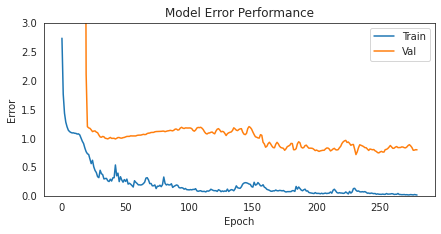

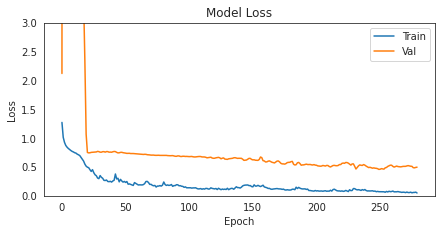

In [31]:
def history_plot(history):
  # list all dictionaries in history
  print(history.history.keys())
  # summarize history for error
  plt.figure(figsize=(7,7))
  plt.subplot(2,1,1)
  plt.plot(history.history['out_mean_squared_error'])
  plt.plot(history.history['val_out_mean_squared_error'])
  plt.title('Model Error Performance')
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.ylim([0, 3])
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(7,7))
  plt.subplot(2,1,2)
  plt.plot(history.history['out_loss'])
  plt.plot(history.history['val_out_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.ylim([0, 3])
  plt.show()
#
history_plot(history)

Visualize Outcome

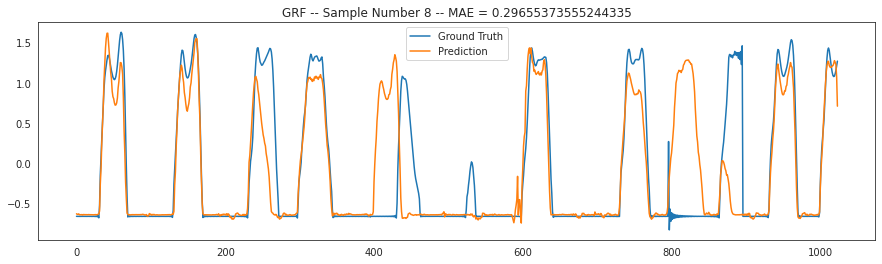

In [23]:
if D_S == 0:
    i = random.randint(0,len(Y_Test));
    #
    MAE = np.mean(np.abs(EEG_App[i].ravel()-Y_Test[i].ravel()));
    #
    plt.figure(figsize=(15, 4));
    plt.plot(Y_Test1[i],label='GRND');
    plt.plot(EEG_App[i].ravel(), label='Pred');
    plt.title(f"EEG -- Sample Number {i} -- MAE = {MAE}");
    plt.legend();
    #
elif D_S == 1:
    i = random.randint(0,len(Y_Test));
    #
    MAE = np.mean(np.abs(EEG_App[0][i].ravel()-Y_Test[i].ravel()))
    #
    plt.figure(figsize=(15,4))
    # plt.subplot(5,1,1)
    plt.plot(Y_Test[i],label='Ground Truth');
    plt.plot(EEG_App[0][i].ravel(), label='Prediction');
    plt.title(f"GRF -- Sample Number {i} -- MAE = {MAE}");
    plt.legend();
    plt.show()
    # plt.subplot(5,1,2)
    # plt.plot((X_Test[i,:,0].ravel()),label='EEG2');
    # plt.title('EEG2')
    # plt.legend();
    # plt.subplot(5,1,3)
    # plt.plot((X_Test[i,:,1].ravel()),label='ACCX2');
    # plt.title('ACCX')
    # plt.legend();
    # plt.subplot(5,1,4)
    # plt.plot((X_Test[i,:,2].ravel()),label='ACCY2');
    # plt.title('ACCY')
    # plt.legend();
    # plt.subplot(5,1,5)
    # plt.plot((X_Test[i,:,3].ravel()),label='ACCZ2');
    # plt.title('ACCZ')
    # plt.legend();

### Evaluate EEG Reconstruction

Construction Error

In [24]:
def Construction_Error(GRND, Pred):
    construction_err = []
    bad_indices = []
    count = 0

    for i in range(len(GRND)):
        MAE = np.mean(np.abs(Pred[i].ravel() - GRND[i].ravel()))
        if MAE < 1:
            construction_err.append(MAE)
        elif MAE >= 1:
            count = count + 1
            bad_indices.append(i)

    print(f'Construction Error : {round(np.mean(construction_err), 3)} +/- {round(np.std(construction_err), 3)}')
    print(f'Number of Bad Predictions = {count}')

    bad_indices = set(bad_indices)
    all_indices = set(np.arange(len(GRND)))
    good_indices = np.array(list(all_indices - bad_indices))
    GRND_NEW = GRND[good_indices]
    PRED_NEW = Pred[good_indices]

    return GRND_NEW, PRED_NEW

In [25]:
[A,B] = Construction_Error(Y_Test,EEG_App[0])

Construction Error : 0.56 +/- 0.183
Number of Bad Predictions = 0


### Save Files

In [26]:
output_directory = 'Patient_Wise_Data/Outputs/Preds_Sub_' + str(Test_Case) + '.h5'
File = h5py.File(output_directory, 'w')
File.create_dataset('EEG_GT', data=Y_Test)
File.create_dataset('EEG_MA', data=X_Test[:,:,0])
File.create_dataset('EEG_Pred', data=EEG_App[0])
File.close()

NameError: ignored

# Infinite Loop to Keep the Tab Alive

In [ ]:
while True:
    pass